In [1]:
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        #if not os.path.exists(filename):
        #    download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 784)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        #if not os.path.exists(filename):
        #    download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    script_dir=os.getcwd()
    rel_path="Input_data/"
    abs_path=os.path.join(script_dir,rel_path)
    X_train = load_mnist_images(abs_path+'train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels(abs_path+'train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images(abs_path+'t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels(abs_path+'t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [2]:
import numpy as np
import sys
import os

from matplotlib import pyplot as plt

# %matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test=load_dataset()

X_train=X_train.reshape((50000,784))
X_test=X_test.reshape((10000,784))

from sklearn import svm

clf=svm.LinearSVC()

clf.fit(X_train,y_train)

X_val=X_val.reshape((10000,784))

clf.score(X_val,y_val)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


0.92049999999999998

In [3]:
for i in range(10):
    print np.linalg.norm(clf.coef_[i])

7.70178974635
10.8619767748
6.92264991913
7.15441351077
9.57456959824
8.8407548438
7.69397085851
8.66512890385
6.50479214014
8.50606755871


In [4]:
one_array=np.where(y_test==1)
one_y_test=y_test[one_array]
one_X_test=X_test[one_array[0],:]
one_decision_test=clf.decision_function(one_X_test)
positive_indices_one=np.where(one_decision_test[:,1]>0)[0]
# temp_gap=np.where(one_decision_train[:,1]>1.1)[0]

In [5]:
positive_indices_one=np.where(one_decision_test[:,1]>0)[0]

In [6]:
no_pca_margins=one_decision_test[positive_indices_one,1]/np.linalg.norm(clf.coef_[1,:])

In [7]:
plt.boxplot(no_pca_margins)

{'boxes': [<matplotlib.lines.Line2D at 0x7f24088c0e50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f24088cdd10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f240886a050>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f240885f9d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f24088cd050>,
  <matplotlib.lines.Line2D at 0x7f24088cd6d0>]}

In [13]:
np.amin(one_decision_test[positive_indices_one,1]/np.linalg.norm(clf.coef_[1,:]))

0.0030111123529526925

In [14]:
np.amax(one_decision_test[positive_indices_one,1]/np.linalg.norm(clf.coef_[1,:]))

0.22829010372278727

In [15]:
np.mean(one_decision_test[positive_indices_one,1]/np.linalg.norm(clf.coef_[1,:]))

0.11955209264037404

In [8]:
from sklearn.decomposition import PCA

rd_list=[10,20,30,40,50,100,331]

max_margins=np.zeros((len(rd_list)))
min_margins=np.zeros((len(rd_list)))
mean_margins=np.zeros((len(rd_list)))
margins=[]

i=0
for rd in rd_list:
    PCA_in_train=X_train
    PCA_in_val=X_val
    PCA_in_test=X_test

    ### Doing PCA over the training data
    #Fitting the PCA model on training data
    pca=PCA(n_components=rd)
    pca.fit(PCA_in_train)
    #Transforming the training, validation and test data
    X_train_dr=pca.transform(PCA_in_train).reshape((50000,rd))
    X_test_dr=pca.transform(PCA_in_test).reshape((10000,rd))
    X_val_dr=pca.transform(PCA_in_val).reshape((10000,rd))

    clf_pca=svm.LinearSVC(dual=False)

    clf_pca.fit(X_train_dr,y_train)

    # val_out_pca=clf_pca.predict(X_val_dr)
    # validation_success_pca=(10000-np.count_nonzero(val_out_pca-y_val))/10000.0
    one_X_test_dr=X_test_dr[one_array[0],:]

    one_decision_test_dr=clf_pca.decision_function(one_X_test_dr)
    positive_indices_one_dr=np.where(one_decision_test_dr[:,1]>0)[0]
    margin_curr=one_decision_test_dr[positive_indices_one_dr,1]/np.linalg.norm(clf_pca.coef_[1,:])
    max_margins[i]=np.amax(one_decision_test_dr[positive_indices_one_dr,1]/np.linalg.norm(clf_pca.coef_[1,:]))
    min_margins[i]=np.amin(one_decision_test_dr[positive_indices_one_dr,1]/np.linalg.norm(clf_pca.coef_[1,:]))
    mean_margins[i]=np.mean(one_decision_test_dr[positive_indices_one_dr,1]/np.linalg.norm(clf_pca.coef_[1,:]))
    margins.append(margin_curr)
    i=i+1
margins.append(no_pca_margins)

In [16]:
fig, ax = plt.subplots(1, 1,figsize=(12,9))
plt.boxplot(margins,0,'',showmeans=True,labels=['10','20','30','40','50','100','331','No PCA'])
plt.title('Box plot of distances to separating hyperplane for Linear SVMs',fontsize=17)
plt.xlabel('Reduced dimensions',fontsize=17)
plt.ylabel('Distance to separating hyperplane',fontsize=17)
plt.savefig('margin_boxplot.eps',format='eps',bbox_inches='tight')

In [19]:
max_margins

array([ 1.27712689,  1.47735755,  1.40172651,  1.37392521,  1.26810879,
        0.85793445,  0.39940548,  0.23059286])

In [20]:
min_margins

array([ 0.00984224,  0.0017355 ,  0.00115389,  0.00361119,  0.01131528,
        0.02969216,  0.00481223,  0.00330256])

In [21]:
mean_margins

array([ 0.81371016,  0.7933079 ,  0.76620759,  0.71970405,  0.716789  ,
        0.47311263,  0.19145593,  0.12096445])

In [26]:
mean_margins=np.append(mean_margins,0.11955209264037404)
min_margins=np.append(min_margins,0.0030111123529526925)
max_margins=np.append(max_margins,0.22829010372278727)

In [27]:
mean_margins

array([ 0.81371016,  0.7933079 ,  0.76620759,  0.71970405,  0.716789  ,
        0.47311263,  0.19145593,  0.12096445,  0.11955209])

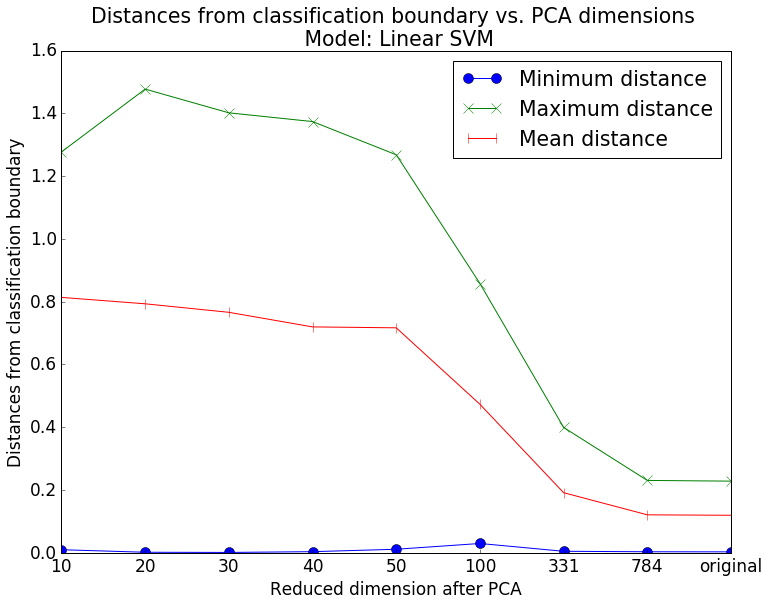

In [30]:
import numpy as np
import matplotlib
matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import os


font ={'size': 17}

matplotlib.rc('font', **font)
#Plot second figure

fig, ax = plt.subplots(1,1,figsize=(12,9))

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

x=np.arange(9)
#labels=['10','20','30','40','50','100','155','561','no_PCA']
labels=['10','20','30','40','50','100','331','784','original']

# script_dir=os.path.dirname(__file__)
# rel_path_o="Output_data/"
# abs_path_o=os.path.join(script_dir,rel_path_o)

# curr_array=np.loadtxt(abs_path_o+'MNIST_test_perform_recons.txt',delimiter=',')
minimum,=plt.plot(x,min_margins,label='Minimum distance',marker='o',markersize=10)

# curr_array=np.genfromtxt(abs_path_o+'MNIST_test_perform_PCA.txt',skip_header=0,delimiter=',')
maximum,=plt.plot(x,max_margins,label='Maximum distance',marker='x',markersize=10)

mean,=plt.plot(x,mean_margins,label='Mean distance',marker='|',markersize=10)

# theo_limit=np.array(97.71)
# y=np.tile(theo_limit,len(labels))
# orig,=plt.plot(x,y,color='black',label='No defense')


xticks, xticklabels=plt.xticks()
plt.xlabel('Reduced dimension after PCA')
plt.ylabel('Distances from classification boundary')
plt.title('Distances from classification boundary vs. PCA dimensions \n Model: Linear SVM')

plt.legend(handles=[minimum,maximum,mean],loc=1)

# xmin = (3*xticks[0] - xticks[1])/2.
# # shaft half a step to the right
# xmax = (3*xticks[-1] - xticks[-2])/2.
# plt.xlim(xmin, xmax)
# plt.ylim(0,100)
plt.xticks(xticks,labels)

script_dir=os.getcwd()
rel_path_p="Plots/"
abs_path_p=os.path.join(script_dir,rel_path_p)

plt.savefig(abs_path_p+'margin_plot.png', bbox_inches='tight')